In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [ ]:
!pip install evaluate
!pip install rouge_score
!pip install rouge-score nltk


In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

dataset = load_dataset("MagedSaeed/xlsum_arabic_experimental")
train_data = dataset["train"]
test_data = dataset["test"]

texts = [x["text"] for x in train_data]
summaries = [x["target"] for x in train_data]

train_texts, val_texts, train_summaries, val_summaries = train_test_split(texts, summaries, test_size=0.1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/574 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4689 [00:00<?, ? examples/s]

**نتأكد انو مافي قيم فاضية**

In [ ]:

import pandas as pd
df = pd.DataFrame(train_data)
print(df.isnull().sum())

gem_id        0
url           0
title         0
target        0
references    0
text          0
dtype: int64


**نحذف الاعمدة غير الضرورية**

In [ ]:
train_data = dataset["train"].select(range(8000))
test_data = dataset["test"].select(range(1200))

In [ ]:
columns_to_remove = ["gem_id", "url", "title", "references"]
train_data = train_data.remove_columns(columns_to_remove)
test_data = test_data.remove_columns(columns_to_remove)

train_data = train_data.rename_column("target", "summary")
test_data = test_data.rename_column("target", "summary")

print("column of  train_data:", train_data.column_names)
print("column of  test_data:", test_data.column_names)


column of  train_data: ['summary', 'text']
column of  test_data: ['summary', 'text']


In [ ]:
print("train:", len(train_data))
print("test:", len(test_data))

train: 8000
test: 1200


**PREPROCESSING**

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [ ]:
def normalize_arabic(text):
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[ًٌٍَُِّْ]', '', text)


In [ ]:
def english_numbers_to_arabic(text):
    translation_table = str.maketrans("0123456789", "٠١٢٣٤٥٦٧٨٩")
    return text.translate(translation_table)

In [ ]:
def has_valid_data(example):
    return all(example[k] not in [None, ''] for k in ["text", "summary"])

dataset_clean = train_data.filter(has_valid_data)

def preprocess_example(example):
    cleaned_text = normalize_arabic(clean_text(example["text"]))
    cleaned_summary = normalize_arabic(clean_text(example["summary"]))
    return {
        "text": cleaned_text,
        "summary": cleaned_summary
    }

processed_dataset = dataset_clean.map(preprocess_example)


Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

**نحسب الأطوال لنحدد احسن MAX Length**

 متوسط طول النص: 420
 أقصى طول نص: 4618
 95% من النصوص تحت: 1162

 متوسط طول الملخص: 25
 أقصى طول ملخص: 219
 95% من الملخصات تحت: 42


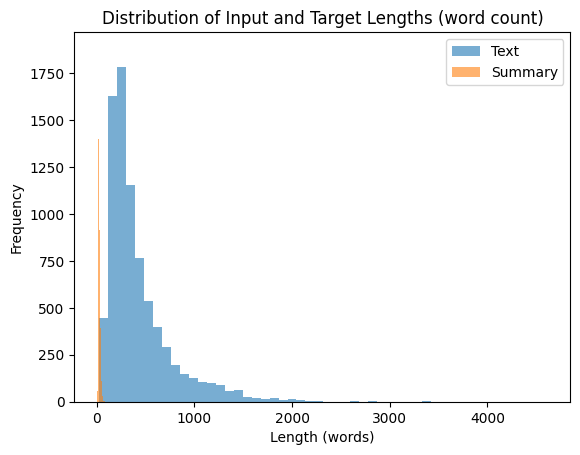

In [ ]:
import matplotlib.pyplot as plt

data = train_data

input_lengths = [len(example["text"].split()) for example in data]
target_lengths = [len(example["summary"].split()) for example in data]


# إحصائيات
print(" متوسط طول النص:", sum(input_lengths) // len(input_lengths))
print(" أقصى طول نص:", max(input_lengths))
print(" 95% من النصوص تحت:", sorted(input_lengths)[int(0.95 * len(input_lengths))])

print("\n متوسط طول الملخص:", sum(target_lengths) // len(target_lengths))
print(" أقصى طول ملخص:", max(target_lengths))
print(" 95% من الملخصات تحت:", sorted(target_lengths)[int(0.95 * len(target_lengths))])

# الرسم
plt.hist(input_lengths, bins=50, alpha=0.6, label='Text')
plt.hist(target_lengths, bins=50, alpha=0.6, label='Summary')
plt.title("Distribution of Input and Target Lengths (word count)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**اعتمادا على هذه النتائج سنختار اقصى طول (يغطي 80%)512 للتيسكت و (يغطي 95%)64 للاختصار**

**Tokenization**

In [ ]:
import re
from collections import Counter

def simple_tokenize(text):
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.strip().split()
    return tokens

def build_vocab(texts, min_freq=2):
    all_tokens = []
    for text in texts:
        tokens = simple_tokenize(text)
        all_tokens.extend(tokens)

    counter = Counter(all_tokens)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

def encode(text, vocab, max_len):
    tokens = simple_tokenize(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens[:max_len]]
    padded = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    return padded[:max_len]


In [ ]:
train_texts = [ex["text"] for ex in train_data]
train_summaries = [ex["summary"] for ex in train_data]

vocab = build_vocab(train_texts + train_summaries, min_freq=2)
print(f"📚 حجم المفردات: {len(vocab)}")


max_text_len = 512
max_summary_len = 64

example_text = train_texts[0]
example_summary = train_summaries[0]

text_ids = encode(example_text, vocab, max_len=max_text_len)
summary_ids = encode(example_summary, vocab, max_len=max_summary_len)

print("🧠 text_ids:", text_ids[:20], "...")
print("🧠 summary_ids:", summary_ids[:10], "...")


📚 حجم المفردات: 93725
🧠 text_ids: [2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 11] ...
🧠 summary_ids: [2540, 156, 13, 1706, 13984, 159, 160, 79, 8271, 162] ...


**بناء TextSummaryDataset**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextSummaryDataset(Dataset):
    def __init__(self, texts, summaries, vocab, max_text_len=512, max_summary_len=64):
        self.texts = texts
        self.summaries = summaries
        self.vocab = vocab
        self.max_text_len = max_text_len
        self.max_summary_len = max_summary_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        summary = self.summaries[idx]

        input_ids = encode(text, self.vocab, self.max_text_len)
        label_ids = encode(summary, self.vocab, self.max_summary_len)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long)
        }


In [ ]:
train_dataset = TextSummaryDataset(train_texts, train_summaries, vocab, max_text_len, max_summary_len)
val_dataset = TextSummaryDataset(val_texts, val_summaries, vocab, max_text_len, max_summary_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
for batch in train_loader:
    print(" first Batch from train_loader:")
    print("input_ids shape:", batch["input_ids"].shape)
    print("labels shape:", batch["labels"].shape)
    break

for batch in val_loader:
    print("\n first Batch from val_loader:")
    print("input_ids shape:", batch["input_ids"].shape)
    print("labels shape:", batch["labels"].shape)
    break


 first Batch from train_loader:
input_ids shape: torch.Size([32, 512])
labels shape: torch.Size([32, 64])

 first Batch from val_loader:
input_ids shape: torch.Size([32, 512])
labels shape: torch.Size([32, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
vocab_size = len(vocab)
summary_len = max_summary_len

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
class ConvSummarizer(nn.Module):
    def __init__(self, vocab_size, summary_len):
        super(ConvSummarizer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.conv = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(0.3)
        self.linear2 = nn.Linear(256, summary_len * vocab_size)
        self.unflatten = nn.Unflatten(1, (summary_len, vocab_size))

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.unflatten(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvSummarizer(vocab_size, summary_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
patience = 5

In [ ]:
train_losses, val_losses, val_accuracies = [], [], []
best_val_loss = float("inf")
best_model_path = "best_model.pth"
patience_counter = 0

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.3f} | Val: {val_loss:.3f} | Acc: {val_acc:.3f}")


Epoch 1/5 | Train: 4.533 | Val: 3.828 | Acc: 0.611
Epoch 2/5 | Train: 3.615 | Val: 3.781 | Acc: 0.610
Epoch 3/5 | Train: 3.426 | Val: 4.011 | Acc: 0.611
Epoch 4/5 | Train: 3.296 | Val: 3.822 | Acc: 0.611
Epoch 5/5 | Train: 3.196 | Val: 3.837 | Acc: 0.611


In [ ]:
import evaluate
rouge = evaluate.load("rouge")


In [ ]:
inv_summary_vocab = {v: k for k, v in vocab.items()}  # فك الترميز

model.eval()
generated_summaries = []
reference_summaries = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=-1)  # [B, summary_len]

        for pred_ids, label_ids in zip(preds, labels):
            pred_tokens = [inv_summary_vocab.get(idx.item(), '') for idx in pred_ids]
            label_tokens = [inv_summary_vocab.get(idx.item(), '') for idx in label_ids]

            pred_text = " ".join(pred_tokens).strip()
            label_text = " ".join(label_tokens).strip()

            generated_summaries.append(pred_text)
            reference_summaries.append(label_text)

rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("\n📊 Final ROUGE Scores:")
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")


📊 Final ROUGE Scores:
ROUGE-1: 0.8486
ROUGE-2: 0.8448
ROUGE-L: 0.8488


### نقوم بزيادة ال epochs

CNN ONLY

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 7
patience = 5

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids)
            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.3f} | Val: {val_loss:.3f} | Acc: {val_acc:.3f}")


Epoch 1/7 | Train: 4.537 | Val: 3.776 | Acc: 0.613
Epoch 2/7 | Train: 3.594 | Val: 3.774 | Acc: 0.613
Epoch 3/7 | Train: 3.409 | Val: 3.842 | Acc: 0.613
Epoch 4/7 | Train: 3.275 | Val: 3.761 | Acc: 0.613
Epoch 5/7 | Train: 3.176 | Val: 3.838 | Acc: 0.613
Epoch 6/7 | Train: 3.116 | Val: 3.873 | Acc: 0.613
Epoch 7/7 | Train: 3.043 | Val: 3.890 | Acc: 0.613


In [ ]:
import evaluate
rouge = evaluate.load("rouge")


In [ ]:
inv_summary_vocab = {v: k for k, v in vocab.items()}

model.eval()
generated_summaries = []
reference_summaries = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=-1)

        for pred_ids, label_ids in zip(preds, labels):
            pred_tokens = [inv_summary_vocab.get(idx.item(), '') for idx in pred_ids]
            label_tokens = [inv_summary_vocab.get(idx.item(), '') for idx in label_ids]

            pred_text = " ".join(pred_tokens).strip()
            label_text = " ".join(label_tokens).strip()

            generated_summaries.append(pred_text)
            reference_summaries.append(label_text)

rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print("\n Final ROUGE Scores:")
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")


 Final ROUGE Scores:
ROUGE-1: 0.8484
ROUGE-2: 0.8446
ROUGE-L: 0.8484


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/arabic_summary_model2.pth"


In [ ]:
torch.save(model.state_dict(), save_path)
print("saved to Google Drive.")


saved to Google Drive.


In [ ]:
loaded_model = ConvSummarizer(vocab_size, summary_len).to(device)
loaded_model.load_state_dict(torch.load(save_path, map_location=device))
loaded_model.eval()
print("✅ تم تحميل النموذج بنجاح.")


✅ تم تحميل النموذج بنجاح.


In [ ]:
def summarize(text, model, vocab, inv_vocab, max_len, device=torch.device("cpu")):
    def simple_tokenize(text):
        text = re.sub(r"[^\w\s]", "", text)
        return text.strip().split()

    def encode(text, vocab, max_len):
        tokens = simple_tokenize(text)
        ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens[:max_len]]
        padded = ids + [vocab["<PAD>"]] * (max_len - len(ids))
        return padded[:max_len]

    def decode(ids, inv_vocab):
        tokens = [inv_vocab.get(i, "") for i in ids]
        return " ".join([tok for tok in tokens if tok not in ["<PAD>", "<UNK>", ""]]).strip()

    input_ids = encode(text, vocab, max_len)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, tuple):  # احتياط إذا بيرجع logits وغيره
            output = output[0]
        pred_ids = torch.argmax(output, dim=-1)[0].cpu().tolist()

    return decode(pred_ids, inv_vocab)


In [ ]:
test_text = "قالت وزارة الصحة إن الحملة الوطنية للتطعيم ستبدأ الأسبوع القادم في جميع المناطق."
generated_summary = summarize(test_text, loaded_model, vocab, inv_summary_vocab, max_len=512, device=device)
print("📝 الملخص:", generated_summary)


📝 الملخص: قال الرئيس في في في في في في في في في في في في


CNN–GRU Seq2Seq


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextSummaryDataset(Dataset):
    def __init__(self, texts, summaries, vocab, max_text_len=512, max_summary_len=64):
        self.texts = texts
        self.summaries = summaries
        self.vocab = vocab
        self.max_text_len = max_text_len
        self.max_summary_len = max_summary_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        summary = self.summaries[idx]

        input_ids = encode(text, self.vocab, self.max_text_len)
        label_ids = encode(summary, self.vocab, self.max_summary_len)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long)
        }


In [ ]:
train_dataset = TextSummaryDataset(train_texts, train_summaries, vocab, max_text_len, max_summary_len)
val_dataset = TextSummaryDataset(val_texts, val_summaries, vocab, max_text_len, max_summary_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
for batch in train_loader:
    print(" first Batch from train_loader:")
    print("input_ids shape:", batch["input_ids"].shape)
    print("labels shape:", batch["labels"].shape)
    break

for batch in val_loader:
    print("\n first Batch from val_loader:")
    print("input_ids shape:", batch["input_ids"].shape)
    print("labels shape:", batch["labels"].shape)
    break


 first Batch from train_loader:
input_ids shape: torch.Size([32, 512])
labels shape: torch.Size([32, 64])

 first Batch from val_loader:
input_ids shape: torch.Size([32, 512])
labels shape: torch.Size([32, 64])


In [ ]:
vocab_size = len(vocab)
summary_len = max_summary_len

In [ ]:
class CNN_GRU_Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, summary_len):
        super(CNN_GRU_Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, embed_dim, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.encoder_gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.decoder_gru = nn.GRU(embed_dim, hidden_dim * 2, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, vocab_size)
        self.summary_len = summary_len

    def forward(self, input_ids, target_ids=None, teacher_forcing_ratio=0.5):
        batch_size = input_ids.size(0)
        device = input_ids.device

        # Encoder
        x = self.embedding(input_ids)
        x = self.relu(self.conv(x.transpose(1, 2)).transpose(1, 2))
        encoder_outputs, hidden = self.encoder_gru(x)
        hidden = torch.cat((hidden[0], hidden[1]), dim=1).unsqueeze(0)

        # Decoder
        outputs = []
        decoder_input = torch.full((batch_size, 1), fill_value=2, dtype=torch.long, device=device)  # <SOS>

        for t in range(self.summary_len):
            embedded = self.embedding(decoder_input)
            output, hidden = self.decoder_gru(embedded, hidden)
            token_logits = self.fc_out(output.squeeze(1))
            outputs.append(token_logits.unsqueeze(1))

            if target_ids is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target_ids[:, t].unsqueeze(1)
            else:
                decoder_input = token_logits.argmax(1).unsqueeze(1)

        return torch.cat(outputs, dim=1)  # [B, T, vocab_size]


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = CNN_GRU_Seq2Seq(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=256,
    summary_len=max_summary_len
).to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

learning_rate = 1e-3
num_epochs = 5
patience = 3
pad_token_id = 0

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        target_ids = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, target_ids)

        outputs = outputs.view(-1, outputs.size(-1))
        targets = target_ids.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"✅ Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

    if 'val_loader' in globals():
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for val_batch in val_loader:
                val_input = val_batch["input_ids"].to(device)
                val_target = val_batch["labels"].to(device)

                val_output = model(val_input, val_target, teacher_forcing_ratio=0)
                val_output = val_output.view(-1, val_output.size(-1))
                val_target = val_target.view(-1)

                val_loss += criterion(val_output, val_target).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f" Val Loss: {avg_val_loss:.4f}")

✅ Epoch 1/5 - Train Loss: 8.8178
 Val Loss: 8.3537
✅ Epoch 2/5 - Train Loss: 7.9398
 Val Loss: 8.2863
✅ Epoch 3/5 - Train Loss: 7.4288
 Val Loss: 8.2602
✅ Epoch 4/5 - Train Loss: 6.8783
 Val Loss: 8.2363
✅ Epoch 5/5 - Train Loss: 6.3009
 Val Loss: 8.2372


In [ ]:
import evaluate
rouge = evaluate.load("rouge")


In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_rouge_bleu(predictions, references):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method1

    total_rouge1 = total_rouge2 = total_rougeL = total_bleu = 0.0
    n = len(predictions)

    for pred, ref in zip(predictions, references):
        scores = rouge.score(ref, pred)
        total_rouge1 += scores['rouge1'].fmeasure
        total_rouge2 += scores['rouge2'].fmeasure
        total_rougeL += scores['rougeL'].fmeasure

        ref_tokens = [ref.split()]
        pred_tokens = pred.split()
        try:
            bleu_score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
        except:
            bleu_score = 0.0
        total_bleu += bleu_score

    avg_rouge1 = total_rouge1 / n
    avg_rouge2 = total_rouge2 / n
    avg_rougeL = total_rougeL / n
    avg_bleu = total_bleu / n

    print("\n📊 Evaluation Metrics:")
    print(f"🔸 ROUGE-1 : {avg_rouge1:.4f}")
    print(f"🔸 ROUGE-2 : {avg_rouge2:.4f}")
    print(f"🔸 ROUGE-L : {avg_rougeL:.4f}")
    print(f"🔹 BLEU     : {avg_bleu:.4f}")

    return {
        "ROUGE-1": avg_rouge1,
        "ROUGE-2": avg_rouge2,
        "ROUGE-L": avg_rougeL,
        "BLEU": avg_bleu
    }




📊 Evaluation Metrics:
🔸 ROUGE-1 : 0.0000
🔸 ROUGE-2 : 0.0000
🔸 ROUGE-L : 0.0000
🔹 BLEU     : 0.2021


{'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0, 'BLEU': 0.20205155046766235}